<a href="https://colab.research.google.com/github/wslbooth/vae-m1-mnist/blob/main/MNIST_SSL_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Latent Feature Extraction (M1) on MNIST Dataset

The goal of this project is to implement the latent feature extraction with a classifier (M1) from [1], and see if we can acheive similar results.

##Section 1: Setup

In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
def accuracy_fn(y_true, y_pred):
  y_pred_classes = y_pred.argmax(dim=1)
  correct = torch.eq(y_true, y_pred_classes).sum().item()
  acc = (correct/len(y_pred))*100
  return acc

In [3]:
seed = 22
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
    target_transform=None
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor(),
    target_transform=None
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.50MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.35MB/s]


In [6]:
from torch.utils.data import random_split, DataLoader

l_size = int(0.01 * len(train_data))
u_size = len(train_data) - l_size
l_data, u_data = random_split(train_data, [l_size,u_size])

batch_size = 32
l_data_loader = DataLoader(dataset=l_data,
                           batch_size=batch_size,
                           shuffle=True)
train_loader = DataLoader(dataset=train_data,
                          batch_size=batch_size,
                          shuffle=True)
test_loader = DataLoader(dataset=test_data,
                         batch_size=100)

In [7]:
from collections import Counter

l_data_labels = [int(train_data.targets[i]) for i in l_data.indices]
l_data_class_counts = Counter(l_data_labels)
l_data_class_counts

Counter({6: 60, 1: 67, 5: 54, 2: 71, 4: 61, 8: 60, 7: 61, 3: 61, 9: 67, 0: 38})

##Section 2: Creating Model Classes




In [8]:
class MLP(nn.Module):
  def __init__(self,
               in_dim,
               hid_dim,
               out_dim):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_dim,hid_dim),
        nn.ReLU(),
        nn.Linear(hid_dim,out_dim)
    )

  def forward(self,x):
    return self.layer_stack(x)

In [9]:
class Encoder(nn.Module):
  def __init__(self, in_dim, hid_dim, latent_dim):
    super().__init__()
    self.fc1 = nn.Linear(in_dim, hid_dim)
    self.fc_mu = nn.Linear(hid_dim, latent_dim)
    self.fc_logvar = nn.Linear(hid_dim, latent_dim)

  def forward(self,x):
    h = F.softplus(self.fc1(x))
    return self.fc_mu(h), self.fc_logvar(h)

def reparameterize(mu, logvar):
  std = torch.exp(0.5*logvar)
  eps = torch.randn_like(std)
  return mu + eps * std

class Decoder(nn.Module):
  def __init__(self, latent_dim, hid_dim, out_dim):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(latent_dim, hid_dim),
        nn.Softplus(),
        nn.Linear(hid_dim, out_dim),
        nn.Sigmoid()
    )
  def forward(self, z):
    return self.net(z)

class VAE(nn.Module):
  def __init__(self, in_dim, hid_dim, latent_dim, out_dim):
    super().__init__()
    self.encoder = Encoder(in_dim, hid_dim, latent_dim)
    self.decoder = Decoder(latent_dim, hid_dim, out_dim)

  def forward(self,x):
    mu, logvar = self.encoder(x)
    z = reparameterize(mu, logvar)
    x_hat = self.decoder(z)
    return x_hat, mu, logvar

In [10]:
class EncoderClassifier(nn.Module):
  def __init__(self, encoder, mlp):
    super().__init__()

    self.encoder = encoder
    self.mlp = mlp

    for param in self.encoder.parameters():
      param.requires_grad = False

  def forward(self,x):
    x = torch.flatten(x,start_dim=1)
    mu, logvar = self.encoder(x)
    return self.mlp(mu)

##Section 3: Model Training and Results

###3.1 Baseline Model Traing

In [11]:
from tqdm.auto import tqdm

m0 = MLP(
    in_dim=784,
    hid_dim=64,
    out_dim=10
).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=m0.parameters(),lr=0.1)

avg_loss_vals = []
train_acc_vals = []
test_acc_vals = []

epochs = 50

for epoch in tqdm(range(epochs)):
  m0.train()
  train_loss = 0
  train_acc = 0
  for batch, (X,y) in enumerate(l_data_loader):
    X,y = X.to(device),y.to(device)
    y_pred = m0(X)
    loss = loss_fn(y_pred, y)
    acc = accuracy_fn(y, y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_acc += acc
  avg_loss = train_loss / len(l_data_loader)
  avg_loss_vals.append(avg_loss)
  avg_train_acc = train_acc / len(l_data_loader)
  train_acc_vals.append(avg_train_acc)

  with torch.no_grad():
    test_acc = 0
    for X,y in test_loader:
      X,y = X.to(device),y.to(device)
      preds = m0(X)
      test_acc += accuracy_fn(y, preds)
  test_acc_vals.append(test_acc/len(test_loader))

  0%|          | 0/50 [00:00<?, ?it/s]

###Baseline Model Results

Text(0, 0.5, 'Testing Accuracy (%)')

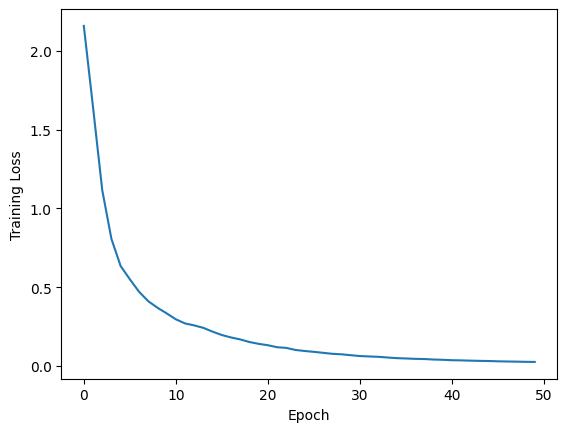

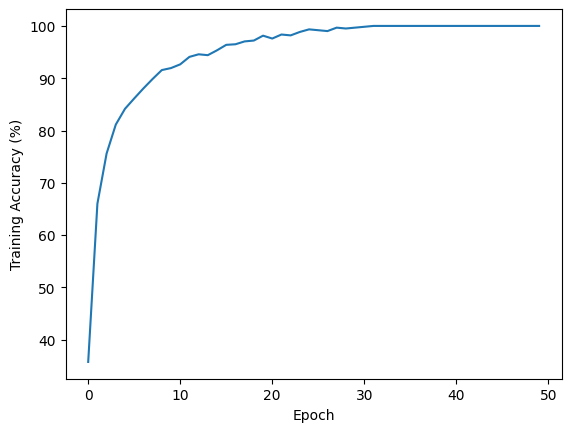

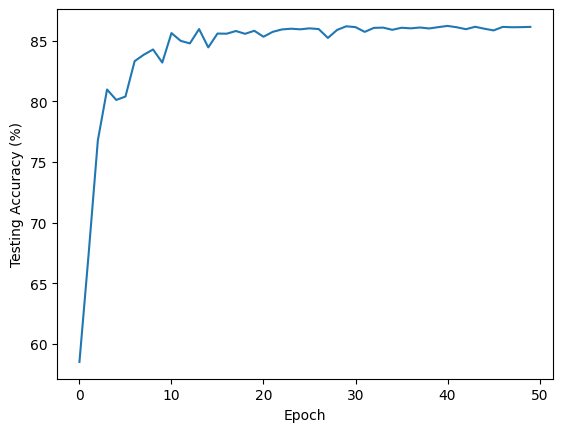

In [12]:
plt.figure()
plt.plot(avg_loss_vals)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.figure()
plt.plot(train_acc_vals)
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy (%)")
plt.figure()
plt.plot(test_acc_vals)
plt.xlabel("Epoch")
plt.ylabel("Testing Accuracy (%)")

In [13]:
print(train_acc_vals)
print(test_acc_vals)
print(f"Max Training Accuracy of {max(train_acc_vals)} after Epoch {np.argmax(train_acc_vals)+1}")
print(f"Max Test Accuracy of {max(test_acc_vals)} after Epoch {np.argmax(test_acc_vals)+1}")
num_params = sum(p.numel() for p in m0.parameters() if p.requires_grad)
print(num_params)

[35.74561403508772, 66.00877192982456, 75.60307017543859, 81.14035087719299, 84.15570175438596, 86.12938596491227, 88.0482456140351, 89.85745614035088, 91.55701754385964, 91.9407894736842, 92.65350877192982, 94.07894736842105, 94.57236842105263, 94.40789473684211, 95.33991228070175, 96.38157894736842, 96.49122807017544, 97.03947368421052, 97.20394736842105, 98.1359649122807, 97.58771929824562, 98.35526315789474, 98.1907894736842, 98.84868421052632, 99.34210526315789, 99.17763157894737, 99.01315789473684, 99.67105263157895, 99.50657894736842, 99.67105263157895, 99.83552631578948, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]
[58.52, 67.43, 76.78, 80.97, 80.11, 80.39, 83.31, 83.84, 84.27, 83.19, 85.62, 84.98, 84.77, 85.95, 84.44, 85.58, 85.57, 85.79, 85.56, 85.81, 85.32, 85.72, 85.92, 85.98, 85.93, 86.01, 85.95, 85.22, 85.88, 86.18, 86.11, 85.72, 86.05, 86.07, 85.89, 86.06, 86.01, 86.08, 86.0, 86.11, 8

###3.2 VAE training

In [14]:
def vae_loss(x, x_hat, mu, logvar, beta=1.0):
  recon_loss = F.mse_loss(x_hat, x, reduction='sum')
  kld = -0.5 * torch.sum(1+logvar - mu.pow(2) - logvar.exp())
  return recon_loss + beta * kld, recon_loss.item(), kld.item()

model_vae = VAE(
    in_dim=784,
    hid_dim=400,
    latent_dim=100,
    out_dim=784
).to(device)

from torch.optim.lr_scheduler import ExponentialLR
optimizer = torch.optim.Adam(model_vae.parameters(), lr=0.001)
schedular = ExponentialLR(optimizer, gamma=0.99)

In [15]:
epochs = 50

loss_vals = []
kld_vals = []
recon_loss_vals = []

for epoch in tqdm(range(epochs)):
  model_vae.train()
  total_loss = 0
  total_kld = 0
  total_recon_loss = 0
  for batch, _ in train_loader:
    batch = batch.view(-1, 784)
    batch = batch.to(device)

    x_hat, mu, logvar = model_vae(batch)
    loss, recon_loss, kld = vae_loss(batch, x_hat, mu, logvar)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    total_kld += kld
    total_recon_loss += recon_loss
  schedular.step()
  avg_loss = total_loss / len(train_loader.dataset)
  loss_vals.append(avg_loss)
  avg_kld = total_kld / len(train_loader.dataset)
  kld_vals.append(avg_kld)
  avg_recon_loss = total_recon_loss / len(train_loader.dataset)
  recon_loss_vals.append(avg_recon_loss)
  #print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, KLdivergence: {avg_kld}, Recon Loss: {avg_recon_loss}")


  0%|          | 0/50 [00:00<?, ?it/s]

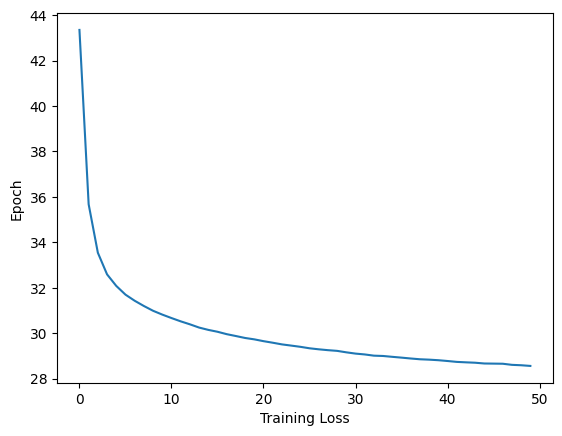

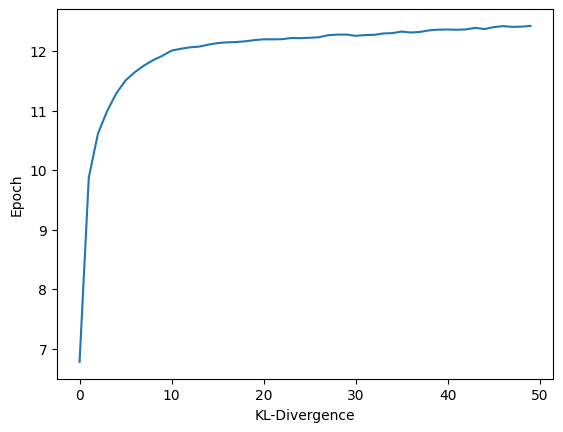

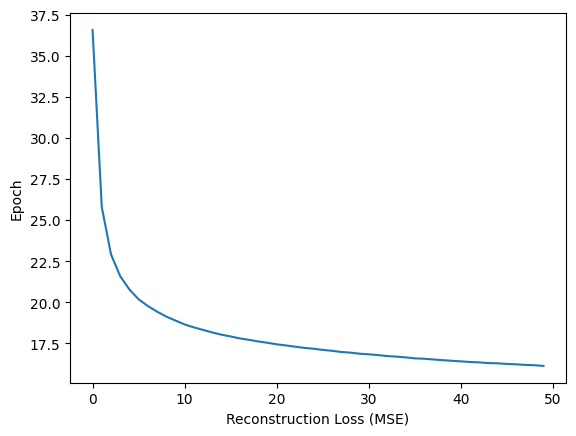

In [16]:
plt.figure()
plt.plot(loss_vals)
plt.xlabel("Training Loss")
plt.ylabel("Epoch")
plt.figure()
plt.plot(kld_vals)
plt.xlabel("KL-Divergence")
plt.ylabel("Epoch")
plt.figure()
plt.xlabel("Reconstruction Loss (MSE)")
plt.ylabel("Epoch")
plt.plot(recon_loss_vals)

###3.3 M1 Training

In [17]:
mlp = MLP(in_dim=100, hid_dim=64, out_dim=10)

m1 = EncoderClassifier(encoder=model_vae.encoder,
                       mlp=mlp).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=m1.parameters(), lr=0.1)

avg_loss_vals = []
train_acc_vals = []
test_acc_vals = []

epochs = 50

for epoch in tqdm(range(epochs)):
  m1.train()
  train_loss = 0
  train_acc = 0
  for batch, (X,y) in enumerate(l_data_loader):
    X,y = X.to(device),y.to(device)
    y_pred = m1(X)
    loss = loss_fn(y_pred, y)
    acc = accuracy_fn(y, y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    train_acc += acc
  avg_loss = train_loss / len(l_data_loader)
  avg_loss_vals.append(avg_loss)
  avg_train_acc = train_acc / len(l_data_loader)
  train_acc_vals.append(avg_train_acc)

  with torch.no_grad():
    test_acc = 0
    for X,y in test_loader:
      X,y = X.to(device),y.to(device)
      preds = m1(X)
      test_acc += accuracy_fn(y, preds)
  test_acc_vals.append(test_acc/len(test_loader))

  0%|          | 0/50 [00:00<?, ?it/s]

###M1 Results

Text(0, 0.5, 'Test Accuracy (%)')

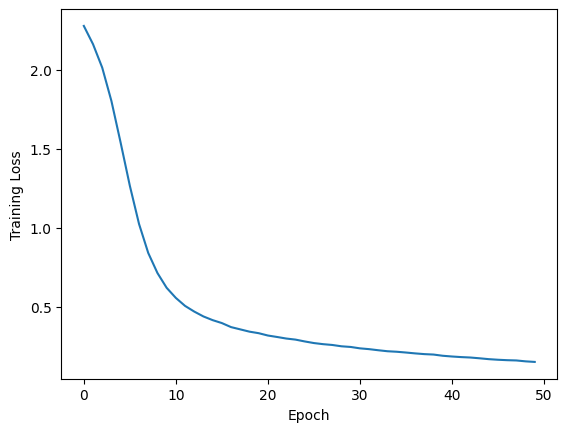

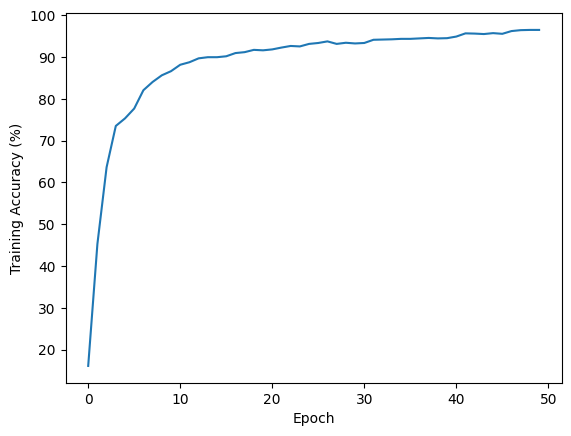

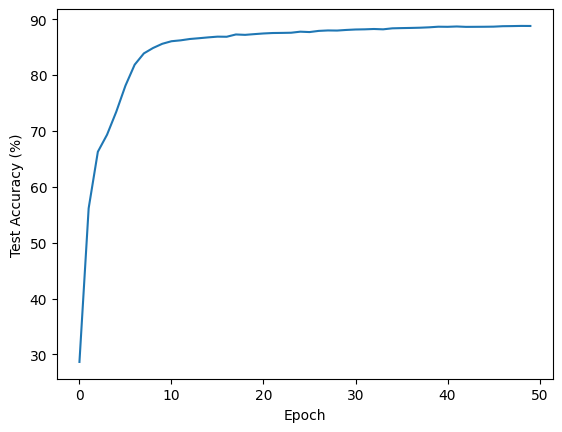

In [18]:
plt.figure()
plt.plot(avg_loss_vals)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.figure()
plt.plot(train_acc_vals)
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy (%)")
plt.figure()
plt.plot(test_acc_vals)
plt.xlabel("Epoch")
plt.ylabel("Test Accuracy (%)")

In [19]:
print(train_acc_vals)
print(test_acc_vals)
print(f"Max Training Accuracy of {max(train_acc_vals)} after Epoch {np.argmax(train_acc_vals)+1}")
print(f"Max Test Accuracy of {max(test_acc_vals)} after Epoch {np.argmax(test_acc_vals)+1}")
num_params = sum(p.numel() for p in m0.parameters() if p.requires_grad)
print(num_params)

[16.11842105263158, 45.28508771929825, 63.651315789473685, 73.51973684210526, 75.32894736842105, 77.68640350877193, 82.07236842105263, 84.04605263157895, 85.6359649122807, 86.62280701754385, 88.15789473684211, 88.7609649122807, 89.69298245614036, 89.96710526315789, 89.96710526315789, 90.18640350877193, 90.95394736842105, 91.1732456140351, 91.72149122807018, 91.61184210526316, 91.83114035087719, 92.26973684210526, 92.65350877192982, 92.54385964912281, 93.14692982456141, 93.36622807017544, 93.75, 93.14692982456141, 93.42105263157895, 93.25657894736842, 93.36622807017544, 94.13377192982456, 94.18859649122807, 94.24342105263158, 94.35307017543859, 94.35307017543859, 94.46271929824562, 94.57236842105263, 94.46271929824562, 94.51754385964912, 94.90131578947368, 95.66885964912281, 95.6140350877193, 95.50438596491227, 95.72368421052632, 95.5592105263158, 96.21710526315789, 96.43640350877193, 96.49122807017544, 96.49122807017544]
[28.65, 56.15, 66.27, 69.33, 73.43, 78.11, 81.86, 83.88, 84.85, 8

###Discussion of Results

As we have seen, our classifier with the latent feature extractor beats our baseline model. After training each model for 50 epochs, the baseline model achieved a max test accuracy of 86.21% after epoch 41, and our M1 achieved a max test accuracy of 88.8%, after epoch 49.

Therefore, we can conclude that the latent feature extraction performed by the encoder, does increase the ability of the classifier to generalize to unseen data. So, our VAE is learning useful discriminitive latent features.

##References:
[1] Kingma, D. P., Rezende, D. J., Mohamed, S., & Welling, M. (2014).  
Semi-Supervised Learning with Deep Generative Models.  
_NeurIPS 27_.  
https://arxiv.org/abs/1406.5298

[2]Doersch, C. (2016).
Tutorial on Variational Autoencoders.
arXiv preprint arXiv:1606.05908.
https://arxiv.org/abs/1606.05908

[3]Kingma, D. P., & Welling, M. (2014).
Auto-Encoding Variational Bayes.
arXiv preprint arXiv:1312.6114.
https://arxiv.org/abs/1312.6114